# **Suicidal Ideation text classification using BERT**


In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.2 MB/s eta 0:00:00


**This version has:**

*   Pre-processing of texts
*   stopword removal
*   Dataset balancing
*   Data augmentation
*   fixed datasets for training and validation
*    (BERTimbau Large)

In [ ]:
!pip install wordcloud

In [ ]:
#hide
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#text preprocessing libraries
import pandas as pd
import re
from unidecode import unidecode
from string import punctuation
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#text classification libraries
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

## **Loading data**

**Loading training dataset**

In [ ]:
url = 'https://drive.google.com/file/d/1i8h-ja_d3uH1FIuSZUqdOw-sLTEz01R_/view?usp=sharing'
file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

# read the data
data_train = pd.read_csv(read_url, index_col=0)

# display the first 5 rows
data_train.head()

,text,target
72,Você está triste e cansado de viver a vida em ...,0.0
73,E eu to tão cansado de viver longe das pessoas...,0.0
74,cansado de viver uma vida baseada em estações,0.0
76,atenção jovens deem o banco para os idosos se ...,0.0
78,Um dia você ta brincando com seus brinquedos j...,0.0


In [ ]:
url = 'https://drive.google.com/file/d/1Ni-hG48RX6nW0965Gm5Wz00xDzR-LmhG/view?usp=sharing'
file_id = url.split('/')[-2]
read_url='https://drive.google.com/uc?id=' + file_id

# read the data
data_test = pd.read_csv(read_url, index_col=0)

# display the first 5 rows
data_test.head()

,text,target
0,Aquela vontade de acabar com a minha vida voltou,1
1,to triste e com vontade de acabar com a minha ...,1
2,Corinthians ta querendo acabar com minha vida ...,0
3,Alguém poderia por favor me dar um tiro a acab...,1
4,TAYLOR TU VAI acabar com a minha vida MULHER,0


## **Data pre-processing**

In [ ]:
nltk.download('rslp')
nltk.download('stopwords')
stopwords_list = stopwords.words("portuguese")
print(stopwords_list)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [ ]:
data_process_train = data_train.copy()
data_process_test = data_test.copy()

In [ ]:
def process_data(data_process):
  old_texts = data_process["text"]
  new_texts = []

  for text in old_texts:
    text = text.lower()
    text = re.sub('@[^\s]+', '', text)
    text = unidecode(text)
    text = re.sub('<[^<]+?>','', text)
    text = ''.join(c for c in text if not c.isdigit())
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    text = ''.join(c for c in text if c not in punctuation)
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    text = ''.join(text.replace("\"", ""))
    text = ''.join(text.replace("'", ""))
    new_texts.append(text)

  return new_texts

In [ ]:
data_process_train['text'] = process_data(data_process_train)
data_process_test['text'] = process_data(data_process_test)

## **Dataset balancing**

<Axes: xlabel='target', ylabel='count'>

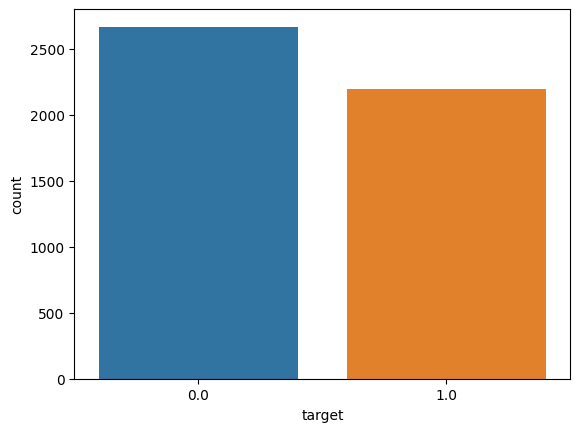

In [ ]:
sns.countplot(x = data_process_train['target'])

<Axes: xlabel='target', ylabel='count'>

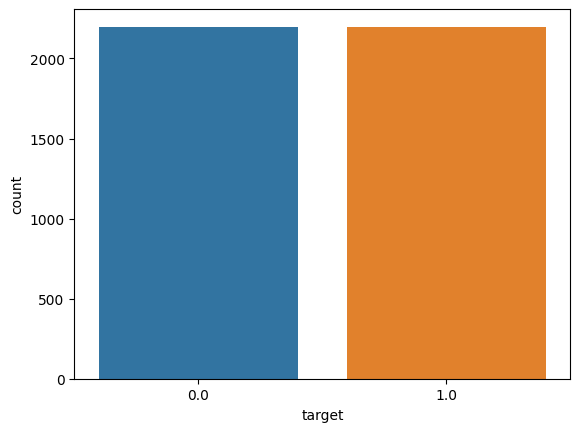

In [ ]:
rus = RandomUnderSampler(random_state= 0)
X_bal, Y_bal = rus.fit_resample(data_process_train[['text']], data_process_train['target'])
sns.countplot(x = Y_bal)

## **Words cloud**

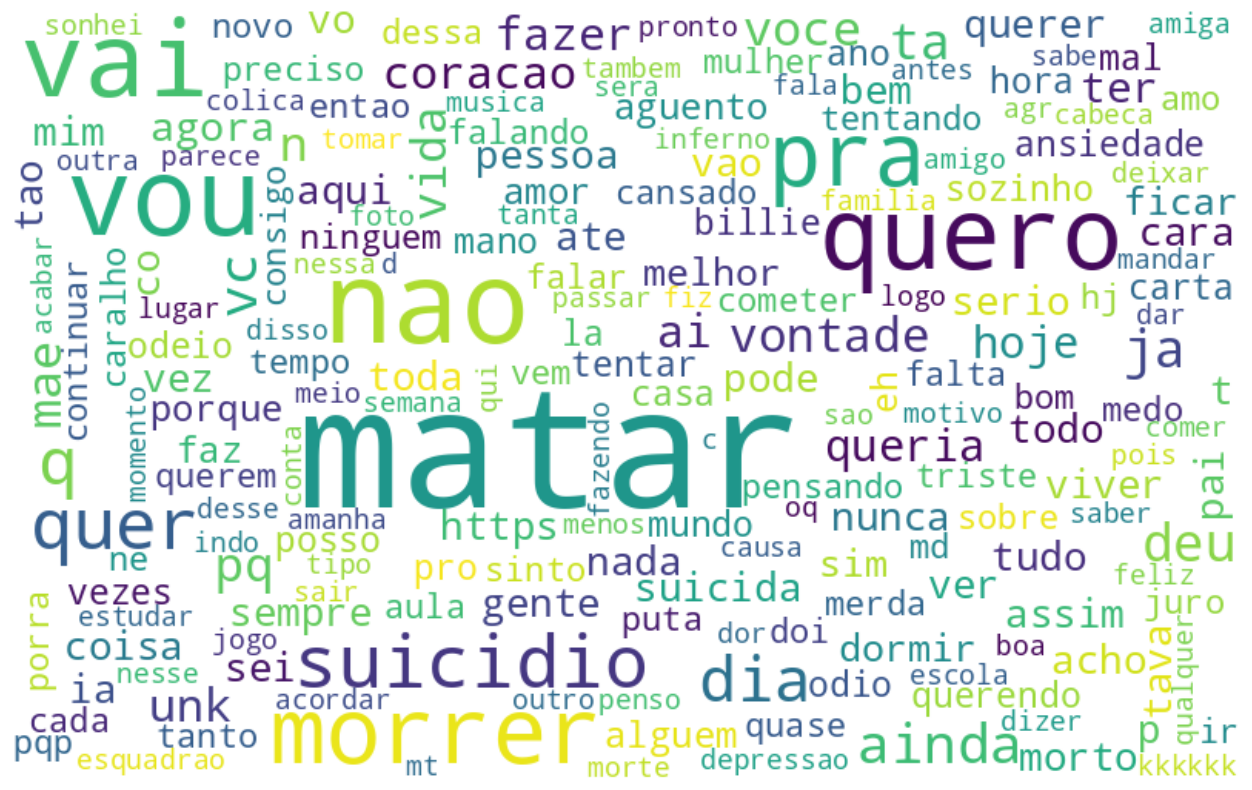

In [ ]:
new_texts = data_process_train["text"]
all_words = ' '.join([text for text in new_texts])
word_cloud = WordCloud(width= 800, height= 500, max_font_size = 110, background_color="white", collocations = False).generate(all_words)
plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Cross validation: K-fold**

In [ ]:
train_df, valid_df, train_label, valid_label = train_test_split(X_bal, Y_bal, test_size=0.20, random_state=42)

In [ ]:
test_df = data_process_test[['text']].copy()
test_label = data_process_test[['target']].copy()

## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
# Load the BERT tokenizer.
#tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=True)
#neuralmind/bert-base-portuguese-cased
#neuralmind/bert-large-portuguese-cased
#bert-base-multilingual-cased
# bert-base-uncased

In [ ]:
PRETRAINED_LM = 'neuralmind/bert-large-portuguese-cased' # BERTimbau Large
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='neuralmind/bert-large-portuguese-cased', vocab_size=29794, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:


In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_label.values)
valid_y = torch.LongTensor(valid_label.values)
test_y = torch.LongTensor(test_label.values)
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([3516]), torch.Size([880]), torch.Size([100, 1]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
train_label.unique()

array([1., 0.])

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Best results: 07 and 08
EPOCHS = 7
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.5381448252634569 
55/55 val loss: 0.40217803066427055 
Epoch:  2


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.35003280324692077 
55/55 val loss: 0.3352550568905744 
Epoch:  3


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.28373717857016756 
55/55 val loss: 0.3138042945076119 
Epoch:  4


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.2373236103660681 
55/55 val loss: 0.3003438146276908 
Epoch:  5


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.2125145814042877 
55/55 val loss: 0.29607212455435233 
Epoch:  6


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.19921793475408445 
55/55 val loss: 0.2974594180556861 
Epoch:  7


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/55 [00:00<?, ?it/s]

220/220 train loss: 0.18736765343187886 
55/55 val loss: 0.2987652704797008 


You can see in the output that the training and validation losses steadily decreases in each epoch.

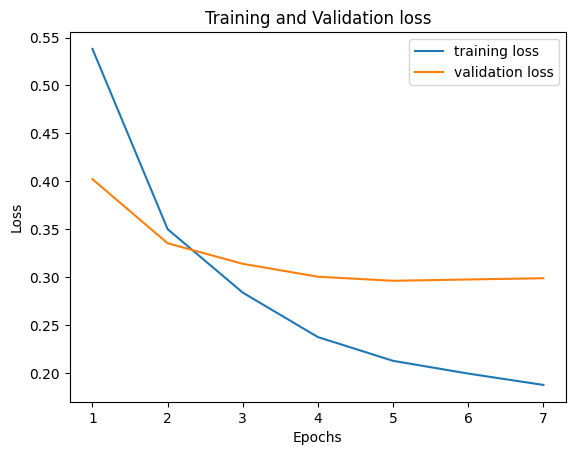

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
label_names = ['negative', 'positive']
label_names

['negative', 'positive']

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_label.to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.90      0.90      0.90       461
    positive       0.89      0.89      0.89       419

    accuracy                           0.90       880
   macro avg       0.90      0.89      0.90       880
weighted avg       0.90      0.90      0.90       880



## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

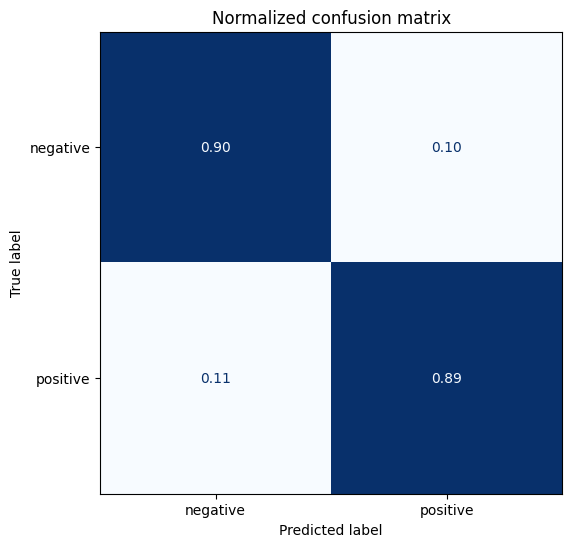

In [ ]:
plot_confusion_matrix(valid_pred,valid_label.to_numpy(),labels=label_names)

## **Prediction**

*Now* let's use the trained model to predict the testing set.



In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_label.to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

    negative       0.94      0.96      0.95        49
    positive       0.96      0.94      0.95        51

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



With the predictions, we can plot the confusion matrix again:

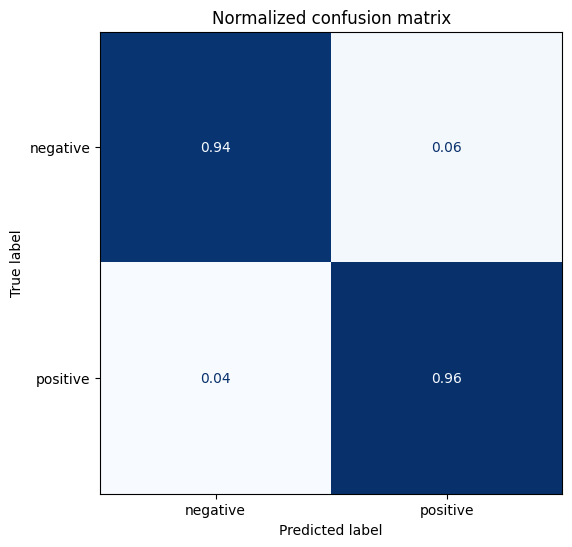

In [ ]:
plot_confusion_matrix(test_pred,test_label.to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df['label'] = test_label
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(5, 3)


,text,label,pred
25,vai voltar pra acabar vida,0,1
33,hj h mae bate deixando machucada ameaca apenas...,1,0
38,maravilha pai vai tirar celular novo psicologi...,1,0
44,matheus kauan acabar vida agora,0,1
51,dessa vez escolheu voce pra acabar vida,0,1


## **Saving results**

In [ ]:
#hide
test_df.to_csv("test_results.csv",index= False)

In [ ]:
MODEL_PATH = "model.bin"
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
import shutil
shutil.copy('/content/model.bin', '/content/drive/MyDrive/model.bin')

'/content/drive/MyDrive/model.bin'